<a href="https://colab.research.google.com/github/slvDev/Malaria-Detection-CNN-Keras/blob/master/Malaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Initial step**

Basic initial step import required libraries


*   os - for handling paths
*   cv2 - best lib for image processing
*   matplotlib - plot images and results
*   zipfile - obviously work with zip archives
*   tensorflow - self-explanatory
*   randrange - we will use for selecting random images
*   shutil - for moving images to a different folder




In [0]:
%matplotlib inline
import os
import cv2
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from random import randrange
from shutil import move

Connecting google drive to colab. 
For some reason uploading archive to colab virtual machine is very slow, so more efficient to upload data ones to google drive and simply connect it. 

In [5]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization. And mount it in preferred path.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Unzip the data.

In [0]:
zip_ref_train = zipfile.ZipFile('/content/drive/My Drive/cell-images-for-detecting-malaria.zip', 'r')
zip_ref_train.extractall('/content')
zip_ref_train.close()

Let's define the paths of unzipped data and explore how many images we have.

In [21]:
ROOT_DATA_DIR = '/content/cell_images'
INF_DIR = os.path.join(ROOT_DATA_DIR, 'Parasitized')
UNINF_DIR = os.path.join(ROOT_DATA_DIR, 'Uninfected')

inf_fnames = os.listdir(INF_DIR)
uninf_fnames = os.listdir(UNINF_DIR)

print(f'Amount of parasitized images: {len(inf_fnames)}')
print(f'Amount of uninfected images: {len(uninf_fnames)}')
print(f'Total Images: {len(inf_fnames) + len(uninf_fnames)}')

Amount of parasitized images: 11024
Amount of uninfected images: 11024
Total Images: 22048


Define the matplotlib figure and plot 4 Parasitized and 4 Uninfected images.

Here I use randrange for selecting a random image index. Rerun the cell for ploting different image.

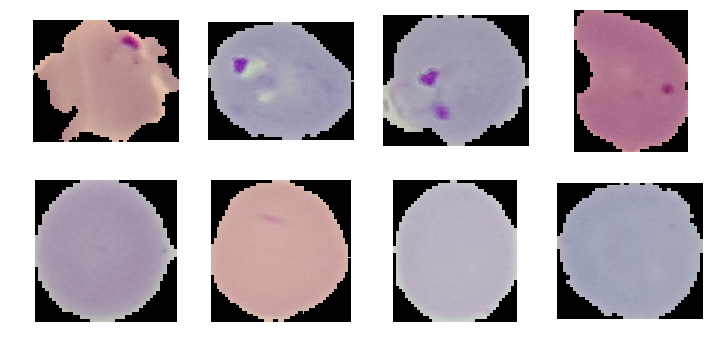

In [8]:
nrows, ncols = 4, 4
fig_size = 3 

fig = plt.gcf()
fig.set_size_inches(ncols * fig_size, nrows * fig_size)

inf_pic_paths = [os.path.join(INF_DIR, inf_fnames[randrange(len(inf_fnames))]) 
                for _ in range(4) 
                ]

uninf_pic_paths = [os.path.join(UNINF_DIR, uninf_fnames[randrange(len(uninf_fnames))]) 
                for _ in range(4) 
                ]

for i, img_path in enumerate(inf_pic_paths + uninf_pic_paths):  
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

Define the function that will split the data.

It's pretty simple. 

Defining names / create folder / moving images.

In [0]:
def split_data(sourse, split_size):
    #Create root folder for valid&test data
    root_folder_name = ROOT_DATA_DIR.strip('/').split('/')[-1]
    valid_test_folder = ROOT_DATA_DIR.replace(root_folder_name,
                                            'valid_test_' + root_folder_name)
    try:
        os.mkdir(valid_test_folder)
    except:
        pass
    
    folders = os.listdir(sourse)
    for folder in folders:
        try:
            os.mkdir(os.path.join(valid_test_folder, folder))
        except:
            pass
        fnames = os.listdir(os.path.join(sourse, folder))
        start_split = len(fnames) - int(len(fnames) * split_size)
        splited_fnames = fnames[start_split:]
        for fname in splited_fnames:
            s_dir = os.path.join(sourse, folder, fname)
            d_dir = os.path.join(valid_test_folder, folder, fname)
            move(s_dir, d_dir)
        print(f'Moved {len(splited_fnames)} files')


Call the function.

*hint. If you want plot images after splitting you will need to redefine file names. Just rerun the cell above the plot.*

In [10]:
split_data(ROOT_DATA_DIR, 0.2)

Moved 2756 files
Moved 2756 files


Our data set contain images with 150 by 150 pixels. 

I found that for this problem we don't need such resolution so I decide to resize the image.

To find out how it will look I use cv2 for resizing and plot the image.

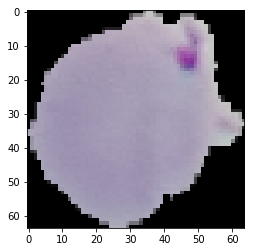

In [11]:
img_size = 64
dim = img_size, img_size

img_path = os.path.join(INF_DIR, inf_fnames[1])
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, dim)

plt.imshow(img)
plt.show()

After splitting we have 2 folders. One contains a training set and another for validation and test sets.

Let's define training generator and add some image augmentation.

In [12]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=45,
        shear_range=0.2,
        vertical_flip=True,
        horizontal_flip=True,
        )

train_generator = train_datagen.flow_from_directory(
        '/content/cell_images',  
        target_size=dim, 
        batch_size=32,
        class_mode='binary',
        )

Found 22046 images belonging to 2 classes.


Now I define validation and test generator. 

I use build in functionality for splitting one folder into two sets.

Singe validation and test set should be from one distribution. This is a perfect solution.

In [13]:
valid_test_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.5
        )

valid_generator = valid_test_datagen.flow_from_directory(
        '/content/valid_test_cell_images',  
        target_size=dim, 
        batch_size=32,
        class_mode='binary',
        subset='training',
        )

test_generator = valid_test_datagen.flow_from_directory(
        '/content/valid_test_cell_images',  
        target_size=dim, 
        batch_size=32,
        class_mode='binary',
        subset='validation',
        )

Found 2756 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.


Define the model.

This is our playground. Add and delete layers, try to find a perfect solution.

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(64, 64, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2), 
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(1, activation='sigmoid')
])


model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

Explore our model.

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 16)        448       
_________________________________________________________________
batch_normalization_v1_6 (Ba (None, 64, 64, 16)        64        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
batch_normalization_v1_7 (Ba (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)        18496     
__________

Finally lets train the model.

I don't define steps_per_epoch since according to official documentation when we use the sequential model we don't need to do this.

Lts's try 50 epoch.

In [19]:
history = model.fit_generator(
        train_generator,
        epochs=50,
        validation_data=valid_generator,
        )

Epoch 1/50
689/689 [==============================] - 66s 96ms/step - loss: 0.3659 - acc: 0.8590 - val_loss: 0.1889 - val_acc: 0.9369
Epoch 2/50
689/689 [==============================] - 62s 91ms/step - loss: 0.1799 - acc: 0.9388 - val_loss: 0.1395 - val_acc: 0.9525
Epoch 3/50
689/689 [==============================] - 62s 90ms/step - loss: 0.1648 - acc: 0.9450 - val_loss: 0.1815 - val_acc: 0.9452
Epoch 4/50
689/689 [==============================] - 62s 90ms/step - loss: 0.1587 - acc: 0.9480 - val_loss: 0.1476 - val_acc: 0.9539
Epoch 5/50
689/689 [==============================] - 62s 90ms/step - loss: 0.1595 - acc: 0.9481 - val_loss: 0.1356 - val_acc: 0.9546
Epoch 6/50
689/689 [==============================] - 62s 91ms/step - loss: 0.1553 - acc: 0.9490 - val_loss: 0.1456 - val_acc: 0.9430
Epoch 7/50
689/689 [==============================] - 63s 91ms/step - loss: 0.1500 - acc: 0.9519 - val_loss: 0.1439 - val_acc: 0.9546
Epoch 8/50
689/689 [==============================] - 62s 90ms

Simple plot our accuracy and loss for understanding problems: "high bias" and "high variance".

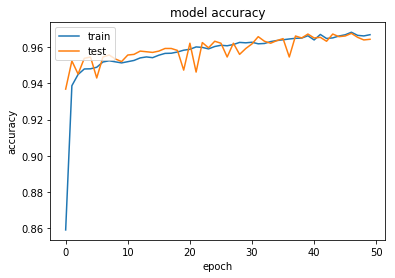

In [22]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

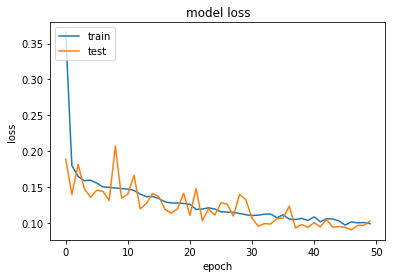

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

After finishing playing with model and we are happy with achieved accuracy.

Evaluate your model on the test set.

In [24]:
model.evaluate_generator(test_generator, verbose=1)

87/87 [==============================] - 3s 38ms/step - loss: 0.0981 - acc: 0.9695


[0.09807781337749684, 0.96952105]